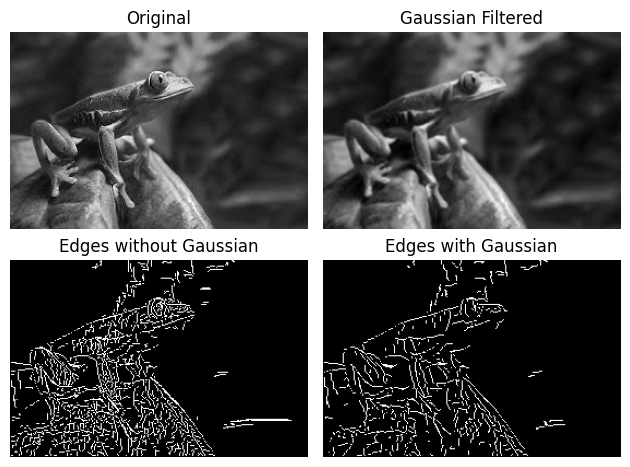

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Create output folder
output_folder = "hw20_outputs"
os.makedirs(output_folder, exist_ok=True)

def main():
    img = cv2.imread("/home/zahin/Desktop/DIP_LAB/images/img5.jpg", 0)

    # --------- Step 1: Noise Reduction (Gaussian) -----------------
    img_filtered = noise_reduction(img, kernel_size=3, sigma=1)

    # --------- Step 2: Gradient Calculation ----------------------
    (Gx, Gy, G, theta) = gradient_estimation(img_filtered)
    nms = non_maximum_supression(G, theta)
    edges_with_gaussian = hysteresis(*threshold(nms, low=20, high=40))

    # --------- Step 2b: Gradient & edges without Gaussian --------
    Gx2, Gy2, G2, theta2 = gradient_estimation(img)  # use original image
    nms2 = non_maximum_supression(G2, theta2)
    edges_without_gaussian = hysteresis(*threshold(nms2, low=20, high=40))

    # --------- Save images ---------------------------------------
    cv2.imwrite(os.path.join(output_folder, "original.png"), img)
    cv2.imwrite(os.path.join(output_folder, "gaussian_filtered.png"), img_filtered)
    cv2.imwrite(os.path.join(output_folder, "edges_without_gaussian.png"), edges_without_gaussian)
    cv2.imwrite(os.path.join(output_folder, "edges_with_gaussian.png"), edges_with_gaussian)

    # --------- Display images ------------------------------------
    img_set = [img, img_filtered, edges_without_gaussian, edges_with_gaussian]
    title = ['Original', 'Gaussian Filtered', 'Edges without Gaussian', 'Edges with Gaussian']
    display(img_set, title)


# ---------------- Noise Reduction -------------------------------
def noise_reduction(img, kernel_size=3, sigma=0):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)


# ---------------- Gradient Estimation --------------------------
def gradient_estimation(img):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    sobel_y = np.array([[-1, -2, -1],
                        [0,  0,  0],
                        [1,  2,  1]], dtype=np.float32)

    Gx = filter_img(img, sobel_x)
    Gy = filter_img(img, sobel_y)
    G = np.hypot(Gx , Gy)
    G = ((G / G.max()) * 255).astype(np.uint8)
    theta = np.arctan2(Gy, Gx)
    return Gx, Gy, G, theta


# ---------------- Filtering Function ---------------------------
def filter_img(input_img, kernel):
    tmp_img = input_img.astype(np.float32)
    input_h, input_w = input_img.shape
    kernel_h, kernel_w = kernel.shape
    output_h = input_h - kernel_h + 1
    output_w = input_w - kernel_w + 1

    output_img = np.zeros((output_h, output_w), dtype = np.float32)
    for h in range(output_h):
        for w in range(output_w):
            roi = tmp_img[h : h + kernel_h, w : w + kernel_w]
            output_img[h, w] = np.sum(roi * kernel)

    return np.clip(output_img, 0, 255).astype(np.uint8)


# ---------------- Non-Maximum Suppression ----------------------
def non_maximum_supression(G, theta):
    h, w = G.shape
    Z = np.zeros((h,w), dtype=np.uint8)
    angle = theta * 180.0 / np.pi 
    angle[angle < 0] += 180

    for i in range(1, h-1):
        for j in range(1, w-1):
            q = r = 255
            a = angle[i,j]

            if (22.5 > a) or (a >= 157.5):
                q = G[i, j+1]
                r = G[i, j-1]
            elif (22.5 <= a) and (a < 67.5):
                q = G[i-1, j+1]
                r = G[i+1, j-1]
            elif (67.5 <= a) and (a < 112.5):
                q = G[i-1, j]
                r = G[i+1, j]
            elif (112.5 <= a) and (a < 157.5):
                q = G[i-1, j-1]
                r = G[i+1, j+1]
            
            Z[i, j] = G[i,j] if (G[i, j] >= q) and (G[i, j] >= r) else 0
    return Z


# ---------------- Double Thresholding -------------------------
def threshold(img, low, high):
    res = np.zeros_like(img)
    strong = 255
    weak = 75

    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img >= low) & (img < high))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    return res, weak, strong


# ---------------- Hysteresis ----------------------------------
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i,j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i,j] = strong
                else:
                    img[i,j] = 0
    return img


# ---------------- Display Function ----------------------------
def display(img_set, img_title):
    for i in range(len(img_set)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(img_set[i], cmap='gray')
        plt.title(img_title[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()
